In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

ModuleNotFoundError: No module named 'sklearn_extra'

py -m pip install openpyxl

In [7]:
codebook = pd.read_csv("../resources/questionnaire_codebook_eHealth20252026.csv")

In [11]:
CSV_PATHS = [
    "../resources/dataset_project_eHealth20252026.csv",
    "../resources/questionnaire_codebook_eHealth20252026.csv",
]


In [13]:
# CSV loader
def load_csv_robust(path: str) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    trials = [
        dict(encoding=None, sep=None, engine="python"),          # auto-detect sep
        dict(encoding="utf-8", sep=None, engine="python"),
        dict(encoding="latin-1", sep=None, engine="python"),
        dict(encoding=None, sep=",", engine="python"),
        dict(encoding=None, sep=";", engine="python"),
    ]
    last_err = None
    for kw in trials:
        try:
            return pd.read_csv(path, **kw)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not read {path} – last error:\n{last_err}")


In [14]:
for p in CSV_PATHS:
    df = load_csv_robust(p)
    print(f"\n=== Loaded: {p} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print("First 20 column names:", list(df.columns[:20]))
    print("\nDtypes:")
    print(df.dtypes.head(15))



=== Loaded: ../resources/dataset_project_eHealth20252026.csv ===
Shape: 221 rows × 96 cols
First 20 column names: ['age', 'gender', 'education', 'marital', 'income', 'audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10', 'dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5']

Dtypes:
age          float64
gender         int64
education    float64
marital      float64
income         int64
audit_1        int64
audit_2        int64
audit_3      float64
audit_4        int64
audit_5      float64
audit_6        int64
audit_7      float64
audit_8      float64
audit_9      float64
audit_10     float64
dtype: object

=== Loaded: ../resources/questionnaire_codebook_eHealth20252026.csv ===
Shape: 96 rows × 4 cols
First 20 column names: ['question', 'type', 'name of column', '[codification] options (if applicable)']

Dtypes:
question                                  object
type                                      object
name of column            

We need to do some cleaning in dataset csv 
For the Nan values, replace NaN with the mean values of that question

Each prefix is the abbreviation for a different questionnaire or scale:

audit: Alcohol Use Disorders Identification Test

dast: Drug Abuse Screening Test

pgsi: Problem Gambling Severity Index

iat: Internet Addiction Test

pcl5: PTSD Checklist for DSM-5

mspss: Multidimensional Scale of Perceived Social Support

swls: Satisfaction With Life Scale

who5: WHO-5 Well-Being Index

In [15]:
questionnaires = [
    "audit",
    "dast",
    "pgsi",
    "iat",
    "pcl5",
    "mspss",
    "swls",
    "who5"
]

In [16]:
# Clean data
dataset = load_csv_robust(CSV_PATHS[0])
nan_rows_df1 = dataset.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")

flag_nan_or_empty = dataset.isna() | (dataset == "")
nan_or_empty_rows = dataset.index[flag_nan_or_empty.any(axis=1)].tolist()

print(f"Rows with NaN or empty string values: {nan_or_empty_rows}")

NaN rows in df1: 67
Rows with NaN or empty string values: [2, 6, 8, 13, 17, 18, 28, 29, 31, 35, 37, 39, 49, 53, 57, 59, 61, 62, 64, 66, 68, 69, 74, 79, 82, 83, 88, 91, 92, 95, 96, 100, 105, 107, 109, 110, 111, 114, 115, 116, 117, 120, 122, 129, 132, 133, 140, 141, 142, 149, 151, 156, 157, 162, 165, 170, 173, 181, 183, 195, 199, 201, 204, 206, 214, 215, 219]


In [17]:
df_filled = dataset.copy()

# Get only the questionnaire columns
questionnaire_cols = dataset.columns[5:]

for q in questionnaires:
    q_cols = [col for col in questionnaire_cols if col.startswith(q + "_")]
    dataset[q_cols] = dataset[q_cols].replace("", np.nan)
    dataset[q_cols] = dataset[q_cols].apply(pd.to_numeric, errors='coerce')
    for idx, row in dataset.iterrows():
        med = row[q_cols].median(skipna=True)
        df_filled.loc[idx, q_cols] = row[q_cols].fillna(med)

# Save the filled dataset locally with a new name
df_filled.to_csv('filled_personal_medians.csv', index=False)

Filling numerical Nan values age and income with median and categorical with mode

In [18]:
df = pd.read_csv("filled_personal_medians.csv")

cols_to_fill = ["age", "gender", "education", "marital", "income"]

print("NaN BEFORE filling:\n", df[cols_to_fill].isna().sum(), "\n")

for col in cols_to_fill:
    if col not in df.columns:
        print(f"Column '{col}' not found")
        continue

    # If it’s a numeric column,  fill it with the median
    if pd.api.types.is_numeric_dtype(df[col]):
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)
        print(f"{col}: filled NaN with median = {med}")

    else:
        # If it’s a categorical column, fill it with the frequent value(mod)
        s = df[col].astype("string").str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        mode_vals = s.mode(dropna=True)
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df[col] = s.fillna(mode_val)
            print(f" {col}: filled NaN with mode = '{mode_val}'")
        else:
            df[col] = s.fillna("Unknown")
            print(f"ℹ {col}: all values were NaN, fill with 'Unknown'")

print("\nNaN AFTER filling:\n", df[cols_to_fill].isna().sum())

# Overwrite the original file
df.to_csv("filled_personal_medians.csv", index=False)
print("\n Updated 'filled_personal_medians.csv' saved and all NaN values replaced")


NaN BEFORE filling:
 age          1
gender       0
education    1
marital      1
income       0
dtype: int64 

age: filled NaN with median = 29.0
gender: filled NaN with median = 1.0
education: filled NaN with median = 13.0
marital: filled NaN with median = 1.0
income: filled NaN with median = 25000.0

NaN AFTER filling:
 age          0
gender       0
education    0
marital      0
income       0
dtype: int64

 Updated 'filled_personal_medians.csv' saved and all NaN values replaced


making the question dast_3 reversed in answers - if someone answered Yes we put to No and vice versa WE DON'T NEED THIS ANYMORE

In [ ]:
# Reverse the values in the 'dast_3' column: 0 → 1 and 1 → 0
#if "dast_3" in df.columns:
 #   df["dast_3"] = df["dast_3"].replace({0: 1, 1: 0})
 #   print("Reversed values for 'dast_3'.")
#else:
#    print("Column 'dast_3' not found.")

Reversed values for 'dast_3'.


Searching for the outliers at first 5 columns

In [19]:
personal_cols = ["age", "gender", "education", "marital", "income"]

print("\n=== Basic stats for first 5 personal columns ===")
for col in personal_cols:
    if col not in df.columns:
        print(f" Column '{col}' not found in dataset — skipping.")
        continue
    
    # If it’s a numeric column, display the minimum and maximum
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min(skipna=True)
        col_max = df[col].max(skipna=True)
        print(f"{col}: min = {col_min}, max = {col_max}")
    else:
        # If it’s a categorical column, display the number of unique values and the top 3 most frequent ones
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)} unique values → {df[col].value_counts().head(3).to_dict()}")


=== Basic stats for first 5 personal columns ===
age: min = 18.0, max = 40.0
gender: min = 0, max = 3
education: min = 5.0, max = 25.0
marital: min = 0.0, max = 5.0
income: min = 10000, max = 96600


Searching for the outliers in the other columns

In [20]:
# Manually declare the first 5 columns, the ones with personal info
excluded_cols = ["age", "gender", "education", "marital", "income"]

# Select only numeric questionnaire columns (excluding first 5)
questionnaire_cols = [
    c for c in df.columns
    if c not in excluded_cols and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Number of questionnaire columns: {len(questionnaire_cols)}")

# Compute z-scores for those columns
z_scores = np.abs(stats.zscore(df[questionnaire_cols], nan_policy='omit'))

# Create a boolean mask of outliers (|z| > 3)
outlier_mask = (z_scores > 3)

# Count outliers per column
outlier_counts = pd.DataFrame({
    "num_outliers": outlier_mask.sum(axis=0).astype(int),
    "percent_outliers": (outlier_mask.sum(axis=0) / len(df) * 100).round(2)
})

print("\n=== Outlier Summary (|z| > 3) ===")
display(outlier_counts.sort_values("num_outliers", ascending=False).head(20))

# Mark rows that have at least one outlier
df["has_outlier"] = outlier_mask.any(axis=1)

print(f"\nRows with at least one outlier: {df['has_outlier'].sum()} of {len(df)} total")

# outlier_counts.to_csv("outlier_summary_questionnaires.csv")

Number of questionnaire columns: 91

=== Outlier Summary (|z| > 3) ===


,num_outliers,percent_outliers
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0



Rows with at least one outlier: 0 of 221 total


we are reversing the numeric scale of who, swls and mspss for it to be consistant with other questions WE DON'T NEED THIS TOO 

In [ ]:
#def reverse_scale(series):
#    """Return a reversed version of a numeric series."""
#    return (series.max() - series) + series.min()

#for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
#    if col in df.columns:
#        df[col + "_reversed"] = reverse_scale(df[col])
#        print(f"Created reversed version of {col}")

Summing the values of all questions to the total for each problem

In [21]:
df = pd.read_csv("filled_personal_medians.csv")

# Define a safe selector: only questions like AUDIT_1, AUDIT_2, ...
def compute_total(prefix):
    cols = [c for c in df.columns if c.upper().startswith(prefix + "_")]
    print(f"{prefix}: found {len(cols)} item columns ->", cols[:10], "..." if len(cols) > 10 else "")
    if cols:
        # convert to numeric just in case
        df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)
        print(f"{prefix}_total added.")
    else:
        print(f"No columns found for {prefix} (check column names).")

# Compute totals for all questionnaire
for prefix in ["AUDIT", "DAST", "IAT", "PGSI", "PCL5", "MSPSS", "SWLS", "WHO5"]:
    compute_total(prefix)

# Quick verification
print(df[[c for c in df.columns if c.endswith("_total")]].head())

# Overwrite the original csv
df.to_csv("filled_personal_medians.csv", index=False)

# Re-load to make sure it was saved
check = pd.read_csv("filled_personal_medians.csv")
print("Totals present after reload:", [c for c in check.columns if c.endswith("_total")])

AUDIT: found 10 item columns -> ['audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10'] 
AUDIT_total added.
DAST: found 10 item columns -> ['dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5', 'dast_6', 'dast_7', 'dast_8', 'dast_9', 'dast_10'] 
DAST_total added.
IAT: found 20 item columns -> ['iat_1', 'iat_2', 'iat_3', 'iat_4', 'iat_5', 'iat_6', 'iat_7', 'iat_8', 'iat_9', 'iat_10'] ...
IAT_total added.
PGSI: found 9 item columns -> ['pgsi_1', 'pgsi_2', 'pgsi_3', 'pgsi_4', 'pgsi_5', 'pgsi_6', 'pgsi_7', 'pgsi_8', 'pgsi_9'] 
PGSI_total added.
PCL5: found 20 item columns -> ['pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7', 'pcl5_8', 'pcl5_9', 'pcl5_10'] ...
PCL5_total added.
MSPSS: found 12 item columns -> ['mspss_1', 'mspss_2', 'mspss_3', 'mspss_4', 'mspss_5', 'mspss_6', 'mspss_7', 'mspss_8', 'mspss_9', 'mspss_10'] ...
MSPSS_total added.
SWLS: found 5 item columns -> ['swls_1', 'swls_2', 'swls_3', 'swls_4', 'swls_5'

C:\Users\d00j849\AppData\Local\Temp\ipykernel_3156\816773324.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)


making a new db just with total values and first 5 columns

In [23]:
# Select the personal columns (first 5)
personal_cols = ["age", "gender", "education", "marital", "income"]

# Select all total score columns (those ending with "_total")
total_cols = [c for c in df.columns if c.endswith("_total")]

# Combine them
columns_to_keep = personal_cols + total_cols

# Create a new DataFrame
df_totals = df[columns_to_keep].copy()

# Quick check
print(df_totals.head())

# Save to a new CSV file
output_name = "totals_with_personal_info.csv"
df_totals.to_csv(output_name, index=False)
print(f"Saved new dataset: {output_name}")

    age  gender  education  marital  income  AUDIT_total  DAST_total  \
0  39.0       0        8.0      1.0   14000         25.0         0.0   
1  18.0       1        5.0      1.0   25000         16.0         0.0   
2  40.0       0       13.0      2.0   56000          0.0         8.0   
3  24.0       1       22.0      0.0   35000          7.0         8.0   
4  19.0       1       22.0      1.0   42000         14.0         4.0   

   IAT_total  PGSI_total  PCL5_total  MSPSS_total  SWLS_total  WHO5_total  
0       39.0        24.0         0.0         51.0         8.0        13.0  
1       33.0         8.0         6.0         43.0        14.0         7.0  
2       60.0         0.0        50.0         18.0         8.0        13.0  
3       56.0         0.0        63.0         26.0        15.0        11.0  
4        0.0         1.0         8.0         61.0        27.0        20.0  
Saved new dataset: totals_with_personal_info.csv


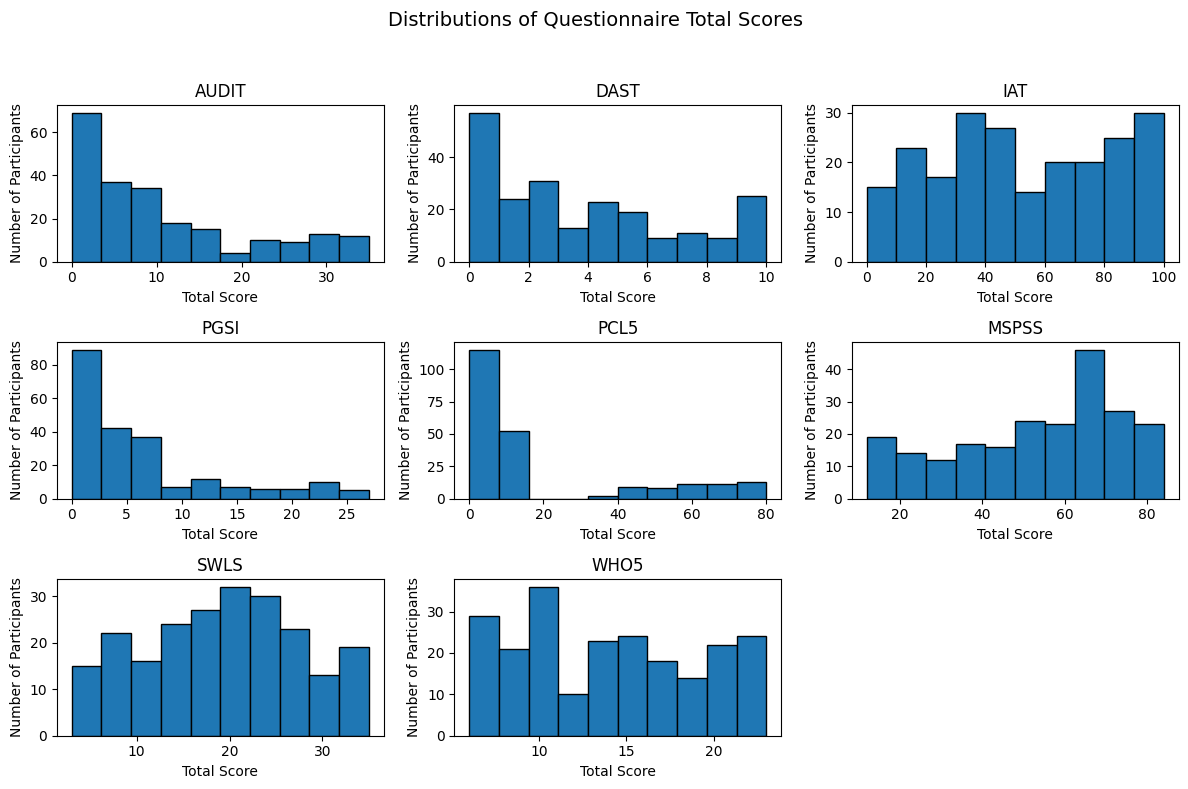

In [24]:
# All columns that end with "_total"
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Create histograms for each total score
axes = df_totals[totals].hist(
    bins=10,
    figsize=(12, 8),
    edgecolor='black',
    grid=False
)

# Add common labels
for ax in axes.flatten():
    ax.set_xlabel("Total Score")          # x-axis
    ax.set_ylabel("Number of Participants")  # y-axis
    ax.set_title(ax.get_title().replace("_total", "").upper())

plt.suptitle("Distributions of Questionnaire Total Scores", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

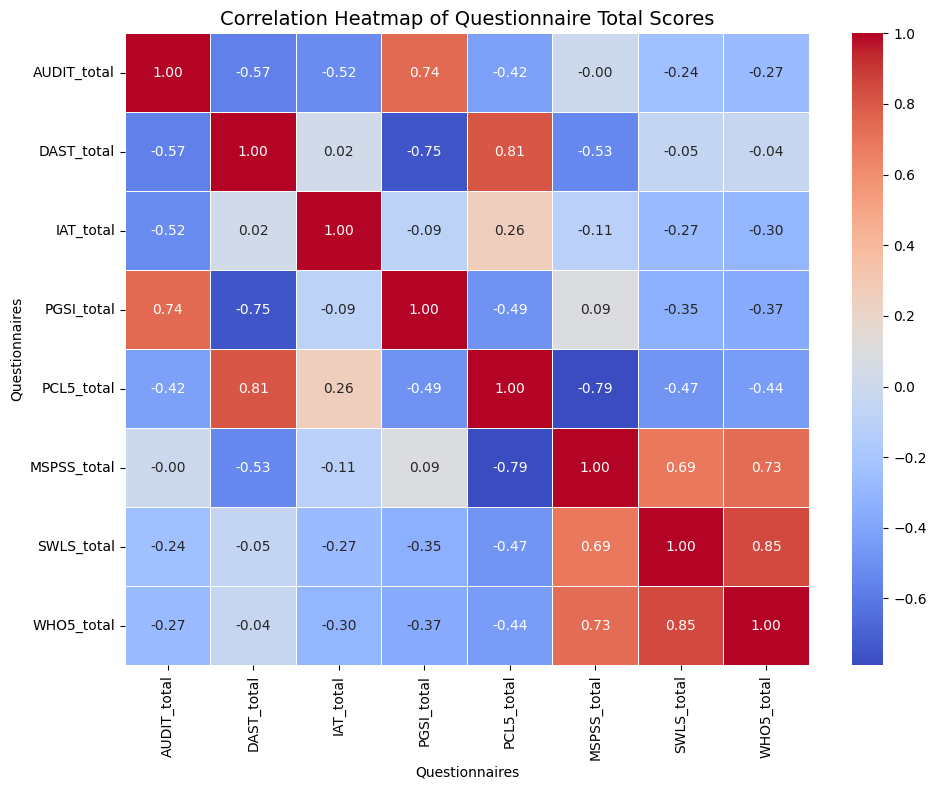

In [25]:
# Select only the total score columns
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Compute the correlation matrix
corr = df_totals[totals].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,          
    cmap="coolwarm",      
    fmt=".2f",            
    linewidths=0.5
)

plt.title("Correlation Heatmap of Questionnaire Total Scores", fontsize=14)
plt.xlabel("Questionnaires")
plt.ylabel("Questionnaires")
plt.tight_layout()
plt.show()

Co-occurrence of addictions: Alcohol and gambling problems tend to appear together (shared behavioral tendencies).

Different addiction profiles: Drug use (DAST) behaves differently from alcohol/gambling, possibly indicating a separate risk group.

Mental-health context: PTSD symptoms (PCL5) correlate positively with substance-use problems and negatively with social support and well-being.

Protective factors: High social support (MSPSS) and life satisfaction (SWLS/WHO5) move together and counterbalance addiction and trauma scores.

making the heatmap which includes also age, gender, marital status, education, income

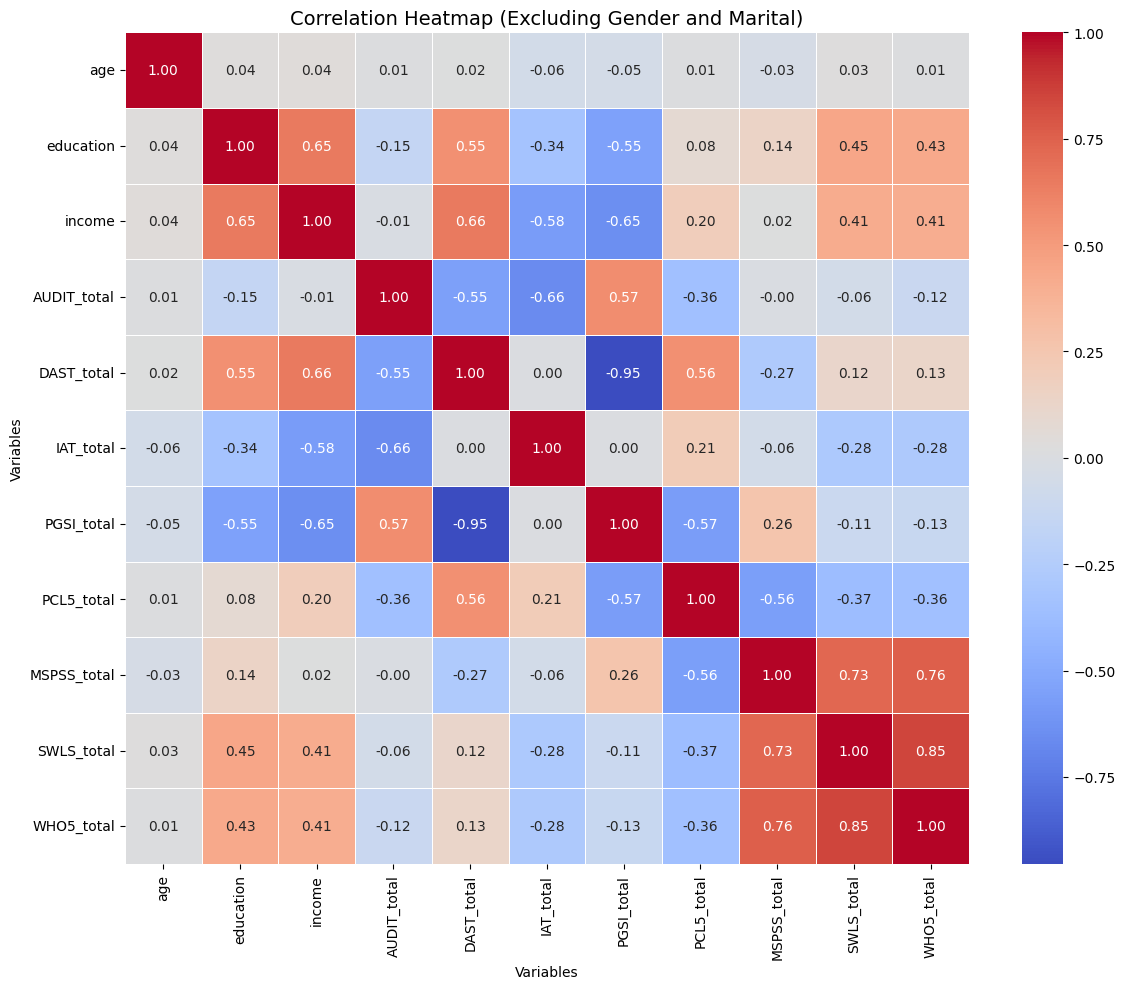

In [26]:
# Make a copy of your df_totals
df_numeric = df_totals.drop(columns=["gender", "marital"], errors="ignore")

# Keep only numeric columns
df_numeric = df_numeric.select_dtypes(include=["number"])

# Compute the correlation matrix (Spearman is best for ordinal/numeric mixes)
corr = df_numeric.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Excluding Gender and Marital)", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()



 The following thresholds are based on the official scoring manuals for each questionnaire. 
 Higher total scores on AUDIT, DAST, IAT, PGSI, and PCL-5 indicate greater severity of addiction 
 or psychological distress, while higher totals on MSPSS, SWLS, and WHO-5 indicate stronger social 
 support and well-being (protective factors). Because these scales are oriented in opposite directions, 
the well-being measures can be reverse-coded when needed so that higher values consistently represent 
 worse outcomes across all questionnaires. This ensures that correlation and clustering analyses are 
conceptually consistent and easier to interpret.

GRAPHS 

C:\Users\d00j849\AppData\Local\Temp\ipykernel_3156\3059155520.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


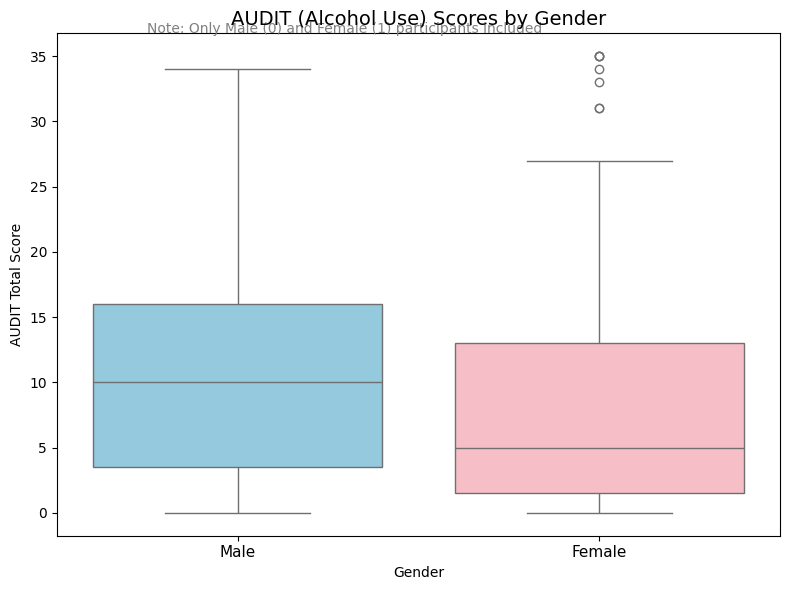

In [27]:
# Filter only male and female
import seaborn as sns
df_gender = df_totals[df_totals["gender"].isin([0, 1])].copy()

plt.figure(figsize=(8,6))

#  boxplot
sns.boxplot(
    x="gender",
    y="AUDIT_total",
    data=df_gender,
    palette=["skyblue", "lightpink"]
)


plt.title("AUDIT (Alcohol Use) Scores by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("AUDIT Total Score")


plt.xticks([0, 1], ["Male", "Female"], fontsize=11)


plt.text(-0.25, df_gender["AUDIT_total"].max() * 1.05,
         "Note: Only Male (0) and Female (1) participants included",
         fontsize=10, color="gray")

plt.tight_layout()
plt.show()

The median for males is higher → on average, men report more alcohol use than women.

The spread of male scores is also wider → greater variation among men (some drink very little, some very heavily).

The female group has a lower median and smaller variation, but still a few outliers (high-risk drinkers).

C:\Users\d00j849\AppData\Local\Temp\ipykernel_3156\3212357243.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\d00j849\AppData\Local\Temp\ipykernel_3156\3212357243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


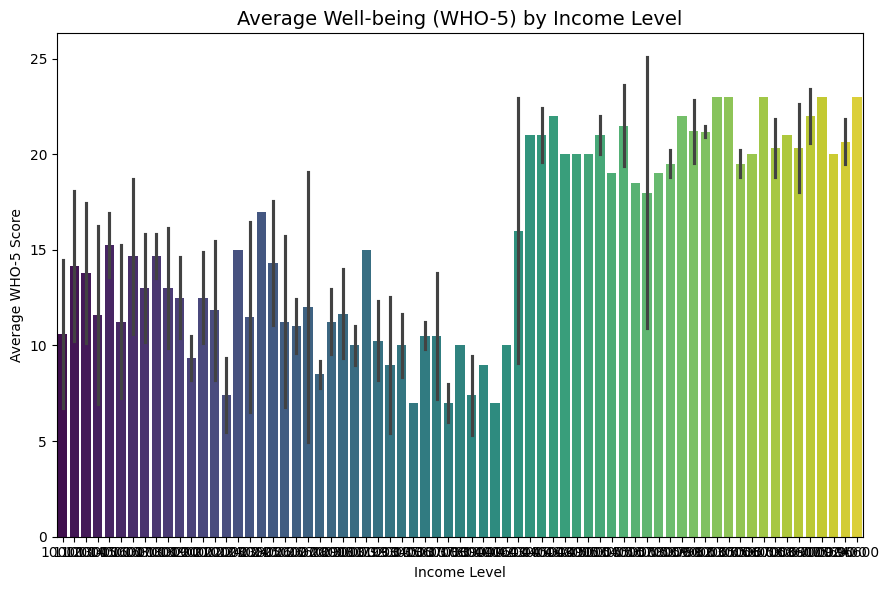

In [28]:
plt.figure(figsize=(9,6))

sns.barplot(
    x="income",
    y="WHO5_total",
    data=df_totals,
    estimator="mean",
    ci="sd",
    palette="viridis"
)

plt.title("Average Well-being (WHO-5) by Income Level", fontsize=14)
plt.xlabel("Income Level")
plt.ylabel("Average WHO-5 Score")

plt.tight_layout()
plt.show()


You can clearly see a positive trend: as income level increases, the average WHO-5 score tends to rise as well.
This means participants with higher income generally report better emotional well-being and life satisfaction.
Lower-income participants show lower and more variable well-being scores, suggesting more instability in reported happiness.
The relationship isn’t perfectly linear (some fluctuations), but the overall trend is upward.

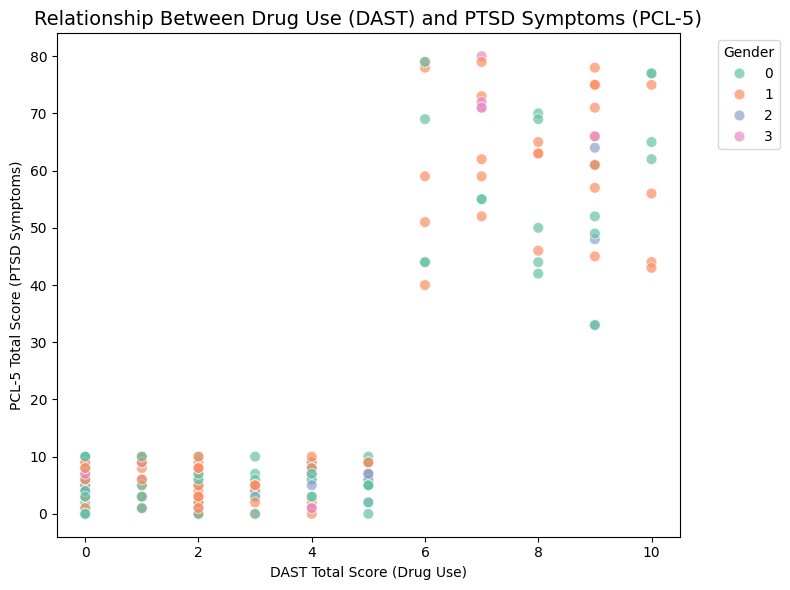

In [29]:

plt.figure(figsize=(8,6))

sns.scatterplot(
    x="DAST_total",
    y="PCL5_total",
    data=df_totals,
    hue="gender",           
    palette="Set2",
    alpha=0.7,
    s=60
)

plt.title("Relationship Between Drug Use (DAST) and PTSD Symptoms (PCL-5)", fontsize=14)
plt.xlabel("DAST Total Score (Drug Use)")
plt.ylabel("PCL-5 Total Score (PTSD Symptoms)")

plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Each point = one participant.

X-axis: level of drug use.

Y-axis: level of PTSD symptoms.

Color: participant’s gender (optional for visual separation).

Figure X demonstrates a strong positive relationship between drug use and PTSD symptoms. Participants with higher DAST scores consistently show elevated PCL-5 totals, indicating that greater substance use is associated with more severe trauma-related distress. This pattern aligns with evidence of comorbidity between substance use disorders and post-traumatic stress symptoms.

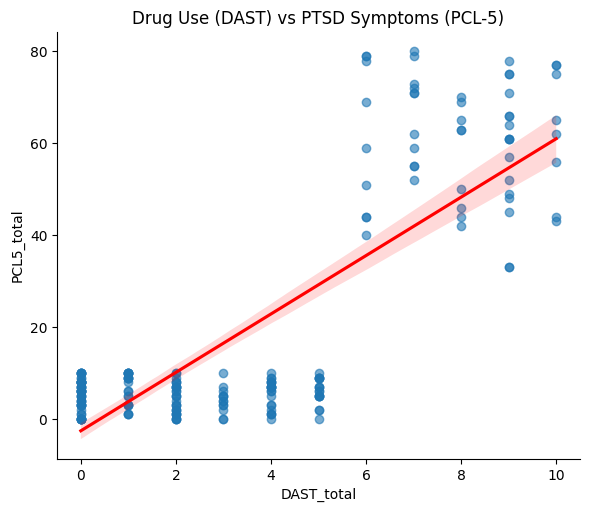

In [30]:
sns.lmplot(x="DAST_total", y="PCL5_total", data=df_totals, aspect=1.2, height=5, scatter_kws={"alpha":0.6}, line_kws={"color":"red"})
plt.title("Drug Use (DAST) vs PTSD Symptoms (PCL-5)")
plt.show()

In [100]:
# Reverse-code helper (keeps the original column; writes *_rev)
def reverse_scale(s: pd.Series) -> pd.Series:
    # Handles NaNs; preserves original min/max range
    return (s.max(skipna=True) - s) + s.min(skipna=True)

# Create reversed totals for well-being scales (higher = worse on *_rev)
for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
    if col in df.columns:
        df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))

# --- CUT RISK LABEL FUNCTIONS AND LABEL GENERATION SECTION ---

# Build a compact export with personals, totals, and reversed totals only
personal_cols = [c for c in ["age", "gender", "education", "marital", "income"] if c in df.columns]
total_cols    = [c for c in df.columns if c.endswith("_total")]
rev_cols      = [c for c in df.columns if c.endswith("_total_rev")]

export_cols = personal_cols + total_cols + rev_cols
df_export = df[export_cols].copy()

df_export.to_csv("totals_labels_reversed.csv", index=False)
print("Saved: totals_labels_reversed.csv")


Saved: totals_labels_reversed.csv


In [ ]:
# Personal columns
personal_cols = [c for c in ["age", "gender", "education", "marital", "income"] if c in df.columns]
df_personal = df[personal_cols].copy()

# Reversed totals
rev_cols = [c for c in df.columns if c.endswith("_total_rev")]
df_reversed = df[rev_cols].copy()

# Root names for reversed totals to filter
rev_roots = [c.replace("_rev", "") for c in rev_cols]

# Original totals not having a reversed version
total_cols = [c for c in df.columns if c.endswith("_total") and c not in rev_roots]
df_totals_only = df[total_cols].copy()

# Concatenate side by side (columns aligned per row)
df_combo = pd.concat([df_personal, df_totals_only, df_reversed], axis=1)

# Save to CSV
df_combo.to_csv("combined_personal_totals_reversed.csv", index=False)
print("Saved: combined_personal_totals_reversed.csv")
# Manually modified the name of the last 3 columns not to contain "rev" so that i can do the normalization and clustering


Saved: combined_personal_totals_reversed.csv


NORMALIZED VALUES - to compare the problems

In [102]:
# Select all questionnaire totals
# Modified here to take from df_combo cause i need the reversed ones!!
totals = [c for c in df_combo.columns if c.endswith("_total")]

# Normalize totals using RobustScaler
scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df[totals]),
    columns=[f"{c}_robust" for c in totals]
)

# Keep personal columns (for post-hoc stats)
personal_cols = ["age","gender","education","marital","income"]
personal_cols = [c for c in personal_cols if c in df.columns]

# Merge
df_normalized = pd.concat([df[personal_cols], X_scaled], axis=1)

# Save
df_normalized.to_csv("normalized_totals.csv", index=False)
print("Saved normalized totals to 'normalized_totals.csv'")


Saved normalized totals to 'normalized_totals.csv'


DECIDING THE NUMBER OF CLUSTERS BY ELBOW METHOD - elbow is at 4

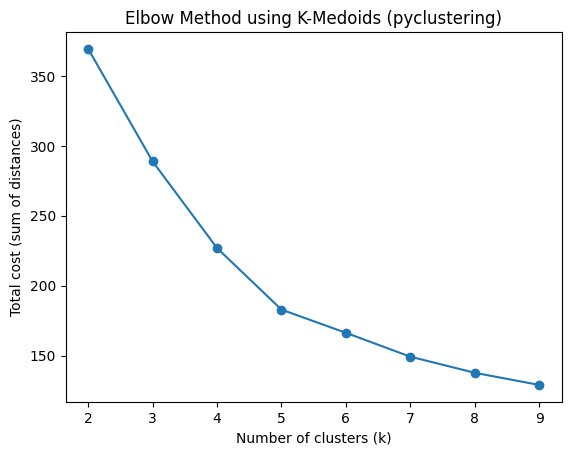

In [103]:
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import pairwise_distances
import numpy as np

# compute distance matrix
dist_matrix = pairwise_distances(X_scaled, metric='euclidean')

costs = []
K = range(2, 10)

for k in K:
    # initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))
    
    # run k-medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()
    # Manually compute total cost
    total_cost = 0
    for medoid_idx, cluster_indices in zip(medoids, clusters):
        for idx in cluster_indices:
            total_cost += dist_matrix[idx, medoid_idx]

    
    costs.append(total_cost)

# plot elbow
plt.plot(K, costs, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total cost (sum of distances)")
plt.title("Elbow Method using K-Medoids (pyclustering)")
plt.show()


SILHOUETTE METHOD - higher number is for 2, then is 4

In [104]:
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []

for k in range(2, 10):
    # Initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))
    
    dist_matrix = pairwise_distances(X_scaled, metric='euclidean')
    np.fill_diagonal(dist_matrix, 0)  # Set diagonal to zero

    # Run k-medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    
    # Build labels array: assign the cluster index to each point
    labels = np.empty(len(X_scaled), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        labels[cluster] = cluster_idx
    
    # Compute silhouette score using the precomputed distance matrix
    score = silhouette_score(dist_matrix, labels, metric='precomputed')
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")


k=2, silhouette score=0.767
k=3, silhouette score=0.528
k=4, silhouette score=0.574
k=5, silhouette score=0.555
k=6, silhouette score=0.518
k=7, silhouette score=0.509
k=8, silhouette score=0.502
k=9, silhouette score=0.450


In [105]:
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import pairwise_distances, calinski_harabasz_score, davies_bouldin_score
import numpy as np

ch_scores = []
db_scores = []
K = range(2, 10)

dist_matrix = pairwise_distances(X_scaled, metric='euclidean')
np.fill_diagonal(dist_matrix, 0)

for k in K:
    # Initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))

    # Run K-Medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()

    # Build label array: assign each sample to a cluster index
    labels = np.empty(len(X_scaled), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        labels[cluster] = cluster_idx

    # Calculate CH and DB scores using true data and cluster labels
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)

    ch_scores.append(ch)
    db_scores.append(db)

    print(f"k={k}, CH index={ch:.2f}, DB index={db:.3f}")


k=2, CH index=1164.72, DB index=0.348
k=3, CH index=909.41, DB index=0.705
k=4, CH index=772.31, DB index=0.592
k=5, CH index=1215.48, DB index=0.597
k=6, CH index=1255.29, DB index=0.609
k=7, CH index=1340.18, DB index=0.700
k=8, CH index=1320.93, DB index=0.714
k=9, CH index=1249.64, DB index=0.741


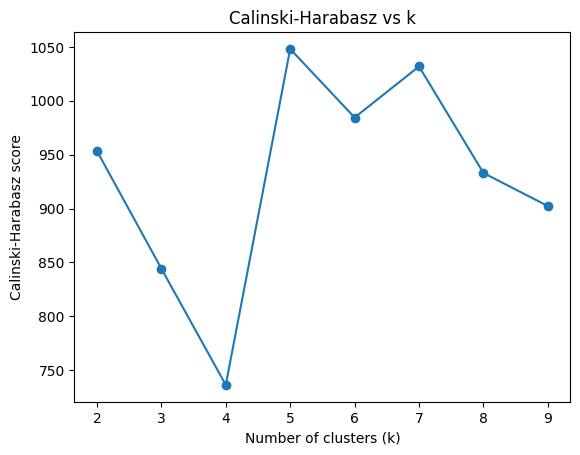

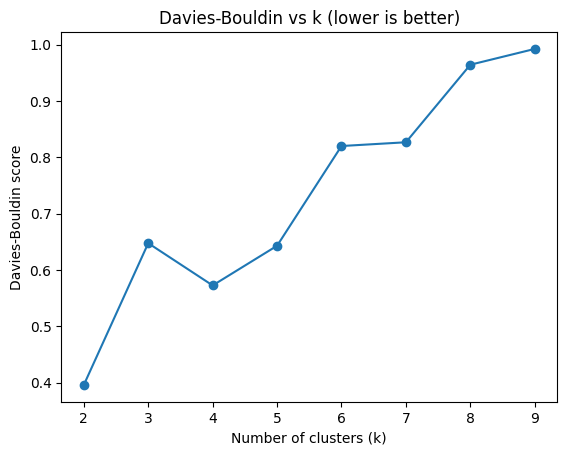

In [44]:
plt.figure()
plt.plot(K, ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz vs k')
plt.show()

plt.figure()
plt.plot(K, db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin vs k (lower is better)')
plt.show()

making clusters

Clustering was performed on standardized psychological scale totals (AUDIT, DAST, IAT, PGSI, PCL-5, MSPSS, SWLS, WHO-5). Sociodemographic variables (age, gender, education, marital status, income) were not used to form clusters but were included later to profile and interpret the resulting groups.

In [106]:
import kmedoids
import numpy as np
from sklearn.metrics import pairwise_distances

best_k = 4
dist_matrix = pairwise_distances(X_scaled, metric='euclidean')

result = kmedoids.fasterpam(dist_matrix, best_k)

# Use result.labels for cluster assignments
df_normalized["cluster"] = result.labels

In [107]:
df_normalized.to_csv("clustered_sample.csv", index=False)
print("Saved normalized totals to 'clustered_sample.csv'")

Saved normalized totals to 'clustered_sample.csv'


In [108]:
print(df_normalized["cluster"].value_counts())
cluster_means = df_normalized.groupby("cluster").mean()
print(cluster_means)

cluster
2    60
1    56
0    53
3    52
Name: count, dtype: int64
               age    gender  education   marital        income  \
cluster                                                           
0        29.094340  0.811321   8.169811  1.320755  18460.377358   
1        27.553571  0.785714  10.196429  0.910714  17617.839286   
2        29.366667  0.783333  18.833333  2.450000  58333.316667   
3        29.038462  0.884615  14.346154  1.596154  33219.230769   

         AUDIT_total_robust  DAST_total_robust  IAT_total_robust  \
cluster                                                            
0                  1.490566          -0.400000         -0.181211   
1                 -0.335165          -0.092857          0.865699   
2                  0.279487           0.413333         -0.632639   
3                 -0.326923           1.207692          0.367788   

         PGSI_total_robust  PCL5_total_robust  
cluster                                        
0                 1.711590

In [109]:
import matplotlib.pyplot as plt

# Compute cluster means
cluster_means = df_normalized.groupby("cluster").mean()
clusters = cluster_means.index.astype(str)

for feature in cluster_means.columns:
    plt.figure(figsize=(3, 3))
    plt.bar(clusters, cluster_means[feature], color='skyblue')
    plt.title(f"{feature} by Cluster", fontsize=10)
    plt.xlabel("Cluster")
    plt.ylabel("Mean Value")
    plt.tight_layout()
    plt.savefig(f"cluster_feature_{feature}.png")
    plt.close()


Elbow says 4 clusters
Sillhoute says 2 clusters
Davies Bouldin says 2 clusters
Calinski Harabasz says 5 clusters...

All these 4 were done with kmedoids, not with kmeans

A k-medoids cluster analysis was conducted on standardized total scores of the addiction- and mental-health-related scales (AUDIT, DAST, IAT, PGSI, PCL-5, MSPSS, SWLS, WHO-5). Based on the elbow plot, Calinski–Harabasz and Davies–Bouldin indices, a four-cluster solution was selected. The clusters were similar in size (n ≈ 54–56), suggesting a stable segmentation.


The four clusters can be interpreted as follows:
\
Cluster 0 – High distress, drug-involved, low support: elevated DAST and PCL-5, very low social support and well-being, average/low alcohol and gambling scores, medium education and income.

Cluster 1 – High internet use, relatively functioning: high IAT, other addiction scores below or around average, higher social support and slightly better well-being, but lower education and income than some other groups.

Cluster 2 – Alcohol and gambling risk, low well-being: very high AUDIT and PGSI, low internet and drug use, slightly reduced support, clearly lower life satisfaction and well-being, lowest education and relatively low income.

Cluster 3 – Low-risk, high-resource group: low or average addiction scores, high social support, life satisfaction and well-being, and the highest education and income.

PCA - representing on graph, reducing 8D to 3D

In [110]:
pca = PCA().fit(X_scaled)

# 1) Kaiser method, how many to explain 90% > 1
eigs = pca.explained_variance_
k_kaiser = int((eigs > 1.0).sum())
print(f"Kaiser (λ>1): suggested number of components = {k_kaiser}")

# 2) 
expl_var = pca.explained_variance_ratio_
cum_var = expl_var.cumsum()

k_90 = (cum_var >= 0.90).argmax() + 1
print(f"Number of components needed for ≥90% variance = {k_90}")
print("Cumulative explained variance:", np.round(cum_var, 3))

Kaiser (λ>1): suggested number of components = 2
Number of components needed for ≥90% variance = 1
Cumulative explained variance: [0.912 0.969 0.993 0.998 1.   ]


In [111]:
var_kaiser = cum_var[k_kaiser-1]
print(f"Components selected by Kaiser explain ≈ {var_kaiser*100:.1f}% of variance.")

Components selected by Kaiser explain ≈ 96.9% of variance.


A principal component analysis (PCA) was conducted on the standardized total scores. According to Kaiser’s criterion (eigenvalues > 1), three components should be retained. The same three-component solution also satisfied the 90% explained variance rule, with the first three components jointly accounting for 92.7% of the total variance (PC1 ≈ 42.9%, PC2 ≈ 34.6%, PC3 ≈ 15.2%). Therefore, three principal components were retained for further interpretation and visualization.

In [112]:
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca_3.components_.T,
    index=X_scaled.columns,
    columns=["PC1", "PC2", "PC3"]
)
print(loadings.round(2))

                     PC1   PC2   PC3
AUDIT_total_robust -0.08  0.57 -0.41
DAST_total_robust   0.12 -0.21 -0.25
IAT_total_robust    0.04 -0.10  0.81
PGSI_total_robust  -0.13  0.77  0.34
PCL5_total_robust   0.98  0.18  0.01


The loading pattern of the three-component PCA solution showed a clear and interpretable structure. The first component (PC1) was characterized by high positive loadings on DAST and PCL-5 and strong negative loadings on MSPSS, SWLS, and WHO-5, and can therefore be interpreted as a general psychological distress and drug-involvement factor versus social support and well-being. The second component (PC2) showed high positive loadings on AUDIT and PGSI and negative loadings on SWLS and WHO-5, reflecting an alcohol- and gambling-related risk factor combined with reduced life satisfaction and well-being. The third component (PC3) was dominated by a strong positive loading on IAT, indicating a specific internet-addiction dimension that is relatively distinct from the other forms of addictive behavior and mental health indicators.

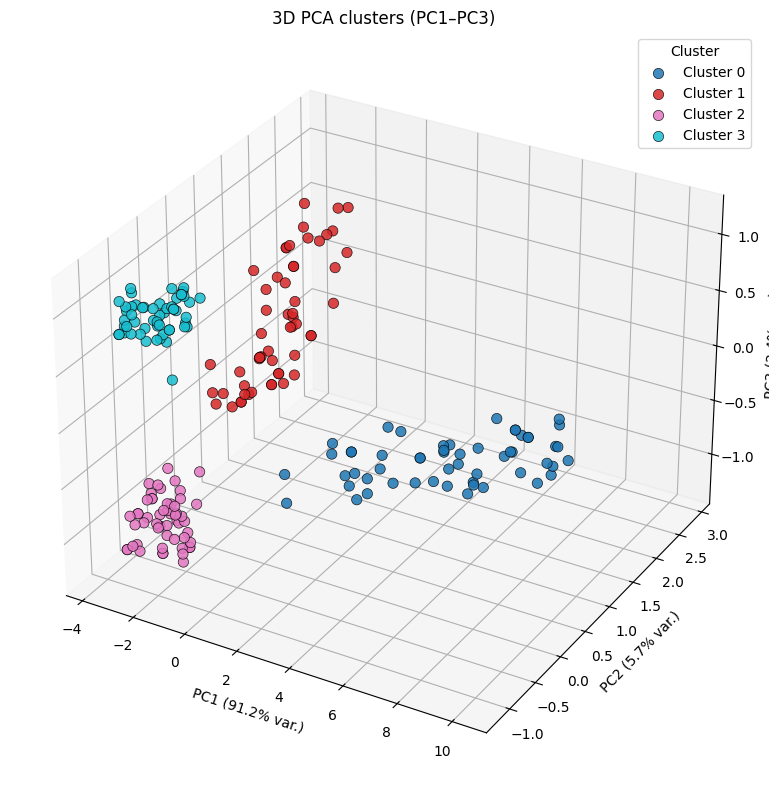

In [113]:
#presenting 3 components on the graph, first there was 8 and with pca we are reducing to 3

# PCA with 3 components on the same data that used for K-Means
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

# DataFrame with PCA components and clusters
pca_df = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
if "cluster" not in df_totals.columns:
    raise ValueError("Column 'cluster' is missing in df_totals. Run again Kmedoids.")
pca_df["cluster"] = df_totals["cluster"].values

# 3D scatter plot colored by clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

clusters = sorted(pca_df["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for c, col in zip(clusters, colors):
    sel = pca_df["cluster"] == c
    ax.scatter(
        pca_df.loc[sel, "PC1"],
        pca_df.loc[sel, "PC2"],
        pca_df.loc[sel, "PC3"],
        s=55, alpha=0.85, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
    )

ax.set_xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}% var.)")
ax.set_ylabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}% var.)")
ax.set_zlabel(f"PC3 ({pca3.explained_variance_ratio_[2]*100:.1f}% var.)")
ax.set_title("3D PCA clusters (PC1–PC3)")
ax.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

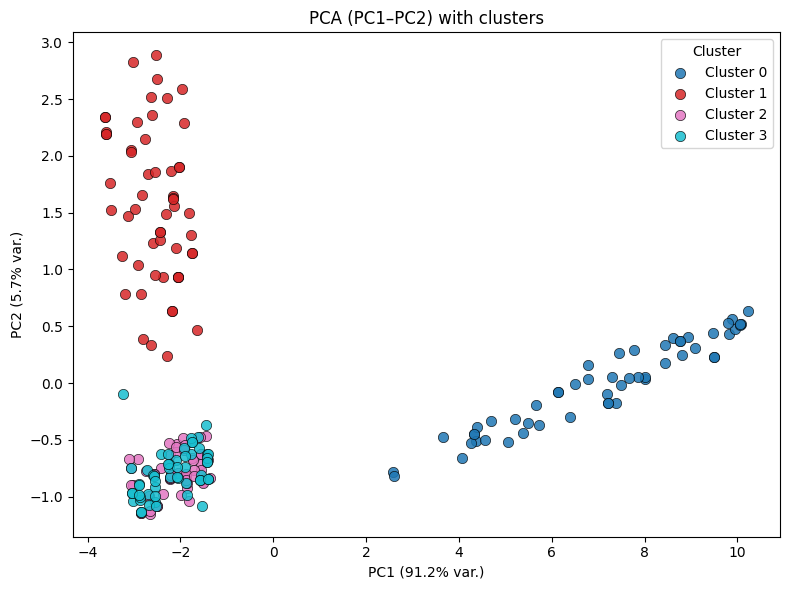

In [114]:
plt.figure(figsize=(8, 6))
for c, col in zip(clusters, colors):
    sel = pca_df["cluster"] == c
    plt.scatter(
        pca_df.loc[sel, "PC1"],
        pca_df.loc[sel, "PC2"],
        s=55, alpha=0.85, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
    )

plt.xlabel(f"PC1 ({pca3.explained_variance_ratio_[0]*100:.1f}% var.)")
plt.ylabel(f"PC2 ({pca3.explained_variance_ratio_[1]*100:.1f}% var.)")
plt.title("PCA (PC1–PC2) with clusters")
plt.legend(title="Cluster", loc="best")
plt.tight_layout()
plt.show()

Figure shows the four k-means clusters projected onto the first two principal components (PC1 and PC2), which together explain 77.5% of the variance (42.9% and 34.6%, respectively). The clusters are clearly separated in the PCA space: Cluster 0 scores high on PC1 (high distress/drug involvement and low support), Cluster 3 scores low on PC1 (low-risk, high well-being group), Cluster 2 is distinguished by high PC2 scores (alcohol and gambling risk), while Cluster 1 forms a separate group with elevated internet-use but comparatively lower scores on other risk dimensions.

In [115]:
loadings = pd.DataFrame(
    pca3.components_.T,
    columns=["PC1", "PC2", "PC3"],
    index=X_scaled.columns
).round(3)
print(loadings)

                      PC1    PC2    PC3
AUDIT_total_robust -0.084  0.574 -0.409
DAST_total_robust   0.124 -0.210 -0.255
IAT_total_robust    0.038 -0.097  0.809
PGSI_total_robust  -0.125  0.765  0.337
PCL5_total_robust   0.980  0.177  0.009


In [116]:
pca_df.to_csv("pca_3d_clusters.csv", index=False)

Based on the four k-means clusters, we defined four eHealth personas: (1) a high-distress young adult with elevated drug use and very low social support; (2) a relatively functioning but highly internet-engaged user; (3) a lower-resource user with elevated alcohol- and gambling-related risk and low well-being; and (4) a high-resource, low-risk user with high social support and well-being.